<h1>Выпускной проект</h1>

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание данных**

    - `data_arc.csv` — данные об электродах;
    - `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
    - `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
    - `data_gas.csv` — данные о продувке сплава газом;
    - `data_temp.csv` — результаты измерения температуры;
    - `data_wire.csv` — данные о проволочных материалах (объём);
    - `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

После уточнее у тимлида стали известные следующие моменты:

    - предсказать необходимо конечную температуру по партии
    - МАЕ должно быть меньше 6 (в идеале)

**План работы**: проведем исследовательский анализ данных, затем - предподготовку данных, подготовку признаков для обучения, и наконец - обучим модель и сделаем выводы.

<h3>Шаг 1: Исследовательский анализ данных</h3>

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

Загрузим данные.

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Теперь рассмотрим таблицы по очереди.

**Данные об электродах**

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Что можно сказать? Пропусков нет, но типы данных для столцов с датой некорректны. Посмотрим по этой таблице: распределения мощностей, времени нагрева, построим диаграммы размаха.

Чтобы получить время нагрева, надо преобразовать столбцы в столбцы с корректным типом данных.

In [5]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Посчитаем время нагрева. Сразу переведем в секунды.

In [6]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0


Столбцы с временем можно удалить.

In [8]:
data_arc = data_arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой'])

Теперь изучим получившуюся таблицу. Получается, сейчас мы рассматриваем акты нагрева как самостоятельные, т.е. по партиям не группируем.

In [9]:
def bp(df, cname, ttle):
    df.boxplot(cname)
    plt.title(ttle)
    plt.show()

In [10]:
def hp(df, cname, xname, ttle):
    df[cname].hist(density=True)
    plt.xlabel(xname)
    plt.ylabel('Частота')
    plt.title(ttle)
    plt.show()

*Активная мощность*

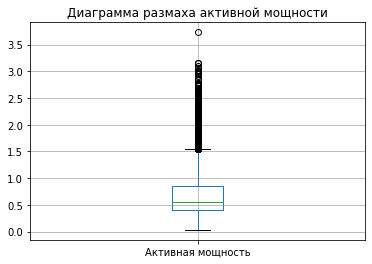

In [11]:
bp(data_arc, 'Активная мощность', 'Диаграмма размаха активной мощности')

Некоторые значения значатся как выбросы, но в целом - они не являются аномальными с точки зрения здравого смысла - на первый взгляд. Посмотрим на гистограмму.

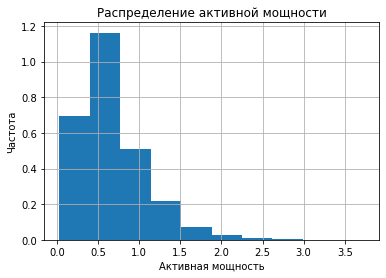

In [12]:
hp(data_arc, 'Активная мощность', 'Активная мощность', 'Распределение активной мощности')

Да, значений выше среднего совсем мало, но в рамках распределения они смотрятся гармонично.

*Реактивная мощность*

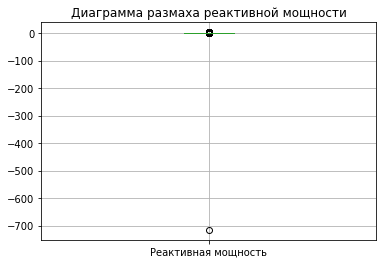

In [13]:
bp(data_arc, 'Реактивная мощность', 'Диаграмма размаха реактивной мощности')

Очевидно, выброс в районе -700. Удаляем и смотрим дальше.

In [14]:
data_arc[data_arc['Реактивная мощность'] < -700]

,key,Активная мощность,Реактивная мощность,Время нагрева
9780,2116,0.495782,-715.504924,109.0


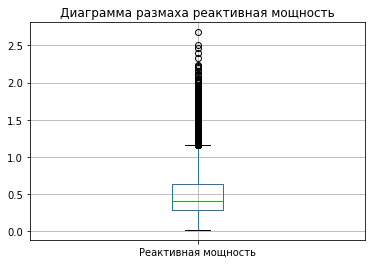

In [15]:
data_arc = data_arc.drop(index = data_arc[data_arc['Реактивная мощность'] < -700].index)
bp(data_arc, 'Реактивная мощность', 'Диаграмма размаха реактивная мощность')

Ситуация аналогичная ситуации с активной мощностью.

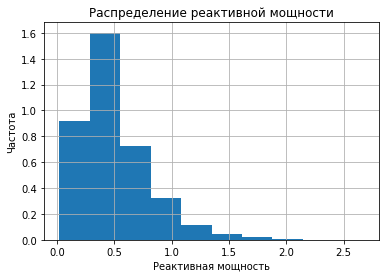

In [16]:
hp(data_arc, 'Реактивная мощность', 'Реактивная мощность', 'Распределение реактивной мощности')

Опять же - выбросы выглядят гармонично.

*Время нагрева*

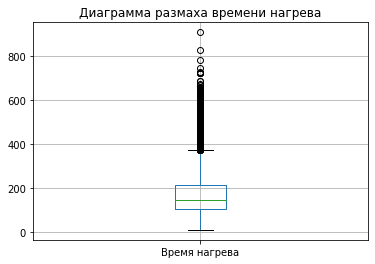

In [17]:
bp(data_arc, 'Время нагрева', 'Диаграмма размаха времени нагрева')

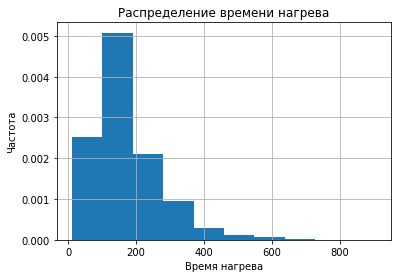

In [18]:
hp(data_arc, 'Время нагрева', 'Время нагрева', 'Распределение времени нагрева')

Явных аномалий нет. 

Какой промежуточный вывод можно сделать? Таблица собрана хорошо. Пропусков нет, аномальное значение пока что выявлено всего одно. Все признаки являются потенциально полезными. Что можно с ними сделать? Можно попробовать использовать:

    - общее время нагрева по партии,
    - тепло, полученное при нагреве (можно получить по формуле - там как раз нужна мощность и время), этот признак может оказывать колоссальное влияние не температуру,
    - средние мощности,
    - посчитать полную мощность.

Следующая таблица.

**Данные о подаче сыпучих материалов (объем)**

In [19]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [20]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Судя по всему, существует 15 вариантов сыпучих примесей. Если их добавляют, то пишут объем, если нет - то NaN. С такими пропусками будет легко справиться.

Вместо построения гистограмм воспользуемся методом describe. Это тоже позволить уловить явные недочеты данных, или приметить характерные черты.

In [21]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Немного смущает максимальное значение в Bulk 12.

In [22]:
data_bulk[data_bulk['Bulk 12'] > 1000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


Выглядит как аномалия. Возможно, при предобработке придется удалить такую строку.

Какой промежуточный вывод можно сделать? Таблица выглядит хорошо. Пропуски понятные и легко заполяемые. Потенциальная аномалия лишь одна. Можно попробовать использовать:

    - признаки, отображающие сколько чего насыпали (т.е. столбцы в исходном виде + с заполненными пропусками),
    - суммарное кол-во веществ (скорее всего, не поможет, но мало ли - вдруг примеси плюс минус эквивалентны между собой и собрав сумму, получится сильно сократить количество признаков).

Следующая таблица.

**Данные о подаче сыпучих материалов (время)**

In [23]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


По пропускам - аналогично предыдущей таблице. Также можно отметить не те типы данных. Таблица, на первый взгляд, выглядит невероятно бесполезной. Что можно попробовать вытащить:

    - одинаковое время у нескольких примесей говорит о том, что их засыпали вместе: можно собрать как новые признаки такие комбинации примесей, почему это может помочь: химическая реакция в комбинации примесей может обуславливать перемены температуры, почему это скорее всего не поможет: сколько комбинаций можно собрать из 15 примесей? очень много, таблица разростется до огромных размеров, и польза таких признаков быстро перекроется.

Следующая таблица.

**Данные о продувке сплава газом**

In [25]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет, столбец всего один. Построим гистограмму и диаграмму размаха.

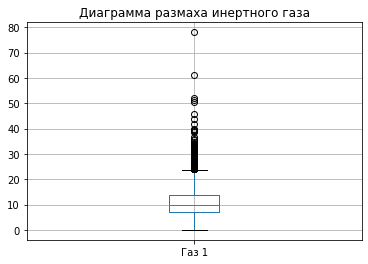

In [27]:
bp(data_gas, 'Газ 1', 'Диаграмма размаха инертного газа')

Есть пара потенциальных аномалий.

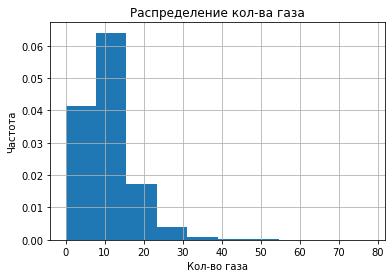

In [28]:
hp(data_gas, 'Газ 1', 'Кол-во газа', 'Распределение кол-ва газа')

Что можно сказать? Тут всего 1 столбец и его необходимо использовать, т.к. газ меняет скорость остывания сплава. Есть слишком большие значения, но, скорее всего, предсказывать мы будем по партиям, а их всего около 3-х тысяч, так что удалять что-то нежелательно.

Следующая таблица.

**Данные о проволочных материалах (объем)**

In [29]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Ситуация похожа на ситуацию с таблицей про сыпучие добавки. Всего 9 видов такого рода материалов. Когда добавлено - ставится объем, в противном случае - пропуск. Отсюда следует, что от пропусков избавиться будет легко. 

Опять же - вместо гистаграмм вызовем describe.

In [31]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Ничего подозрительного.

Таблица полезная. Что можно попробовать использовать?

    - признаки, отображающие сколько и чего добавили(т.е. столбцы в исходном виде + с заполненными пропусками),
    - суммарное кол-во веществ - по аналогии с таблицей про сыпучие добавки.

Следующая таблица.

**Данные о проволочных материалах (время)**

In [32]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Опять же - таблица сильно похожа на такую же для сыпучих материалов. Из нее можно попытаться вытащить сочетания примесей, но в целом - особой пользы она не несет. С пропусками здесь справиться легко.

Следующая и последняя таблица.

**Результаты измерения температуры**

In [34]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [35]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


В столбце с температурой есть пропуски. Но в любом случае - посмотрим на распределение.

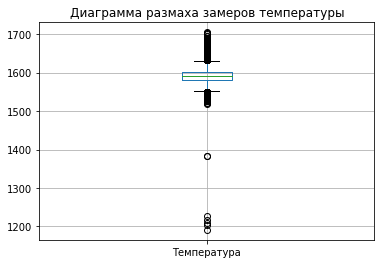

In [36]:
bp(data_temp, 'Температура', 'Диаграмма размаха замеров температуры')

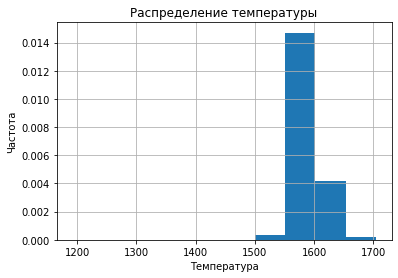

In [37]:
hp(data_temp, 'Температура', 'Температура', 'Распределение температуры')

Очень интересная ситуация с температурой - размах значений очень большой. Многие измерение помечены вообще как выбросы. Также - на каждую партию по несколько измерений, очевидно, на разных этапах.

Судьба этой таблицы зависит от того, какую же температуру требуется предсказывать в итоге. Если финальную, то многие значения будут удалены и, весьма вероятно, распределение сильно поправится + станет поменьше пропусков. 

Признак времени измерение потребуется лишь для того, чтобы оставить лишь последнее измерение (если нужно действительно лишь последнее измерение).

Что можно сказать по исследовательскому анализу данных в целом?

**Вывод по Шагу 1**: итак, мы изучили все 7 таблиц, построили графики, просмотрели общую информацию. В общем и целом данные выглядят пригодными для построения качественной модели - многие пропуски выглядят простыми для устранения, признаки - информативными, некоторые из них обладают потенциалом для генерации новых признаков. Но есть и бесполезные, но их куда меньше. Аномалии присутствуют, одна - совсем грубая (возможно, это даже просто некорректное значение) уже удалена. Траектория работы с остальными зависит от того, нужно ли работать с данными по партиями (в случае предсказания конечно температуры) или же нужно предсказывать температуру после некоторого набора операций (например, нагрели + насыпали bulk 12 => получили определенную температуру), потому что партий всего около трех тысяч (мало!). 

<h3>Шаг 2: Подготовка признаков</h3>

Итак, теперь необходимо собрать таблицу для обучения. Она должна позволять построить качественную модель, а также не иметь пропусков.

Как известно, предсказывать мы будем по партиям.

Будем поддерживать массив с номерами партий, которые мы не будем использовать. Так, уже есть одна - в ней некорректно замерили мощность.

In [38]:
bad_samples = [2116]

Начнем с таблицы с результатами измерений.

**Результаты измерения температуры**

Итак, вспомним, там у нас время замера, результат и номер партии. Хотелось бы использовать первый замер температуры как признак - это стартовая точка, она оказывает влияние на результат. Отсюда вытекает - мы не можем использовать партии, в которых замер происходил 1 раз. 

Сгруппируем. Пропуски заполнять не будем - так мы отловим партии с одним замером.

In [39]:
num_of_meas = data_temp.groupby('key')['Температура'].count()

In [40]:
'Кол-во негодных партий: {}, это {:.2%} от общего числа'.format(len(num_of_meas[num_of_meas < 2]), len(num_of_meas[num_of_meas < 2]) / len(num_of_meas))

'Кол-во негодных партий: 741, это 23.04% от общего числа'

Придется удалять большой процент данных. Как известно, сталь плавится при температуре от 1450 до 1520, то есть - она могла попасть в ковш обладая любой из этих температур + диапазон температур выше (мало ли, перегрели). Слишком большая неопределенность создается, если не брать начальную температуру.

In [41]:
one_meas = num_of_meas[num_of_meas<2].index
bad_samples.extend(list(one_meas))

Для каждой партии сохраним результаты первого и последнего измерения, а также даты этих замеров, чтоб исключить операции над субстанцией до первого замера и после последнего.

In [42]:
data = data_temp.groupby('key').agg({'Температура':['first', 'last'], 'Время замера':['first', 'last']})

In [43]:
data.head()

Температура                 Время замера                     
          first    last                first                 last
key                                                              
1        1571.0  1613.0  2019-05-03 11:16:18  2019-05-03 11:30:39
2        1581.0  1602.0  2019-05-03 11:37:27  2019-05-03 11:59:12
3        1596.0  1599.0  2019-05-03 12:13:17  2019-05-03 12:34:57
4        1601.0  1625.0  2019-05-03 12:52:57  2019-05-03 12:59:25
5        1576.0  1602.0  2019-05-03 13:23:19  2019-05-03 13:36:01

Удалим негодные партии.

In [44]:
data = data.drop(index=bad_samples)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 1 to 2499
Data columns (total 4 columns):
(Температура, first)     2474 non-null float64
(Температура, last)      2474 non-null float64
(Время замера, first)    2474 non-null object
(Время замера, last)     2474 non-null object
dtypes: float64(2), object(2)
memory usage: 96.6+ KB


Поменяем названия столбцов и поправим типы данных.

In [46]:
data.set_axis(['temp_before', 'temp_after', 'time_before', 'time_after'], axis='columns')

C:\Users\Acer\anaconda3\envs\practicum\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  """Entry point for launching an IPython kernel.


In [47]:
data['time_before'] = pd.to_datetime(data['time_before'])
data['time_after'] = pd.to_datetime(data['time_after'])

In [48]:
data.head()

,temp_before,temp_after,time_before,time_after
key,,,,
1,1571.0,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1581.0,1602.0,2019-05-03 11:37:27,2019-05-03 11:59:12
3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57
4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25
5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 1 to 2499
Data columns (total 4 columns):
temp_before    2474 non-null float64
temp_after     2474 non-null float64
time_before    2474 non-null datetime64[ns]
time_after     2474 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


В индексе номер партии, это нас устроит.

Разберемся со следующими таблицами.

**Данные о подаче сыпучих материалов**

У нас информация по количеству подачи и по времени подачи.

Сохраним только те добавки, которые были совершены между изначальным и конечным замером температуры.

In [50]:
bulks = data_bulk_time.columns[1:]

In [51]:
for i in bulks:
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i])

In [52]:
for i in data.index:
    start = data.loc[i, 'time_before']
    end = data.loc[i, 'time_after']
    str_to_w = data_bulk_time[data_bulk_time.key == i]
    if len(str_to_w) == 0:
        continue
    else:
        for j in bulks:
            if (str_to_w[j] > end).reset_index(drop=True)[0] or (
                str_to_w[j] < start).reset_index(drop=True)[0]:
                ind = data_bulk[data_bulk.key == i].index
                data_bulk.loc[ind, j] =  np.nan

Таблица со временем больше не пригодится. А в таблице с количествои заменим пропуски на нули.

In [53]:
data_bulk = data_bulk.fillna(0)

Соединим таблицы.

In [54]:
data = data.join(data_bulk.set_index('key'))
data.head()

,temp_before,temp_after,time_before,time_after,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,2019-05-03 11:37:27,2019-05-03 11:59:12,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 1 to 2499
Data columns (total 19 columns):
temp_before    2474 non-null float64
temp_after     2474 non-null float64
time_before    2474 non-null datetime64[ns]
time_after     2474 non-null datetime64[ns]
Bulk 1         2406 non-null float64
Bulk 2         2406 non-null float64
Bulk 3         2406 non-null float64
Bulk 4         2406 non-null float64
Bulk 5         2406 non-null float64
Bulk 6         2406 non-null float64
Bulk 7         2406 non-null float64
Bulk 8         2406 non-null float64
Bulk 9         2406 non-null float64
Bulk 10        2406 non-null float64
Bulk 11        2406 non-null float64
Bulk 12        2406 non-null float64
Bulk 13        2406 non-null float64
Bulk 14        2406 non-null float64
Bulk 15        2406 non-null float64
dtypes: datetime64[ns](2), float64(17)
memory usage: 466.6 KB


Партии, для которых нет информации о добавках, придется удалить.

In [56]:
data = data.dropna()

Перейдем к следующей таблице.

**Данные о подаче материалов через проволоку**

Проведем действия, аналогичные предыдущему этапу, только для другого рода материалов.

In [57]:
wires = data_wire_time.columns[1:]
for i in wires:
    data_wire_time[i] = pd.to_datetime(data_wire_time[i])

In [58]:
for i in data.index:
    start = data.loc[i, 'time_before']
    end = data.loc[i, 'time_after']
    str_to_w = data_wire_time[data_wire_time.key == i]
    if len(str_to_w) == 0:
        continue
    else:
        for j in wires:
            if (str_to_w[j] > end).reset_index(drop=True)[0] or (
                str_to_w[j] < start).reset_index(drop=True)[0]:
                ind = data_wire[data_wire.key == i].index
                data_wire.loc[ind, j] =  np.nan

Заменяем пропуски, соединяем.

In [59]:
data_wire = data_wire.fillna(0)
data = data.join(data_wire.set_index('key'))
data.head()

,temp_before,temp_after,time_before,time_after,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,2019-05-03 11:37:27,2019-05-03 11:59:12,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим на пропуски.

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406 entries, 1 to 2499
Data columns (total 28 columns):
temp_before    2406 non-null float64
temp_after     2406 non-null float64
time_before    2406 non-null datetime64[ns]
time_after     2406 non-null datetime64[ns]
Bulk 1         2406 non-null float64
Bulk 2         2406 non-null float64
Bulk 3         2406 non-null float64
Bulk 4         2406 non-null float64
Bulk 5         2406 non-null float64
Bulk 6         2406 non-null float64
Bulk 7         2406 non-null float64
Bulk 8         2406 non-null float64
Bulk 9         2406 non-null float64
Bulk 10        2406 non-null float64
Bulk 11        2406 non-null float64
Bulk 12        2406 non-null float64
Bulk 13        2406 non-null float64
Bulk 14        2406 non-null float64
Bulk 15        2406 non-null float64
Wire 1         2330 non-null float64
Wire 2         2330 non-null float64
Wire 3         2330 non-null float64
Wire 4         2330 non-null float64
Wire 5         2330 non-null

Опять немного удалим.

In [61]:
data = data.dropna()

Заканчивая работать с примесями, добавим еще два столбца: суммарное кол-во примесей одного вида и суммарное кол-во примесей другого вида. На случай, если примеси плюс-минус эквивалентны, мы сможем использовать только эти столбцы.

In [62]:
data['bulk_sum'] = data[bulks].sum(axis=1)
data['wire_sum'] = data[wires].sum(axis=1)

Перейдем к следующим, последним двум таблицам.

**Данные о газе и электродах**

Данные о газе просто соединим с текущей таблицей.

In [63]:
data = data.join(data_gas.set_index('key'))

Теперь к таблице об электродах. Посчитаем для каждого акта нагрева полную мощность, а также - полученное сплавом кол-во тепла.

In [64]:
data_arc['full_power'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5

In [65]:
data_arc['heat'] = data_arc['full_power'] * data_arc['Время нагрева']

In [66]:
data_arc.head()

,key,Активная мощность,Реактивная мощность,Время нагрева,full_power,heat
0,1,0.976059,0.687084,228.0,1.193639,272.149755
1,1,0.805607,0.520285,185.0,0.959010,177.416785
2,1,0.744363,0.498805,172.0,0.896038,154.118502
3,1,1.659363,1.062669,365.0,1.970470,719.221394
4,1,0.692755,0.414397,148.0,0.807239,119.471318


Оставим пока что все столбцы. Переименуем те, что на русском и соединим с остальной таблицей.

In [67]:
data_arc = data_arc.rename(columns={'Активная мощность': 'active_power', 'Реактивная мощность' : 'reactive_power', 
                                   'Время нагрева' : 'heat_time'})

In [68]:
data_arc = data_arc.groupby('key').sum()

In [69]:
data = data.join(data_arc)

Посмотрим, что получилось.

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 1 to 2499
Data columns (total 36 columns):
temp_before       2330 non-null float64
temp_after        2330 non-null float64
time_before       2330 non-null datetime64[ns]
time_after        2330 non-null datetime64[ns]
Bulk 1            2330 non-null float64
Bulk 2            2330 non-null float64
Bulk 3            2330 non-null float64
Bulk 4            2330 non-null float64
Bulk 5            2330 non-null float64
Bulk 6            2330 non-null float64
Bulk 7            2330 non-null float64
Bulk 8            2330 non-null float64
Bulk 9            2330 non-null float64
Bulk 10           2330 non-null float64
Bulk 11           2330 non-null float64
Bulk 12           2330 non-null float64
Bulk 13           2330 non-null float64
Bulk 14           2330 non-null float64
Bulk 15           2330 non-null float64
Wire 1            2330 non-null float64
Wire 2            2330 non-null float64
Wire 3            2330 non-null float64

In [71]:
data.head()

,temp_before,temp_after,time_before,time_after,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 8,Wire 9,bulk_sum,wire_sum,Газ 1,active_power,reactive_power,heat_time,full_power,heat
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,43.0,0.000000,29.749986,4.878147,3.183241,1098.0,5.826395,1442.377754
2,1581.0,1602.0,2019-05-03 11:37:27,2019-05-03 11:59:12,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,582.0,96.052315,12.555561,3.052598,1.998112,811.0,3.649216,881.233565
3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,34.0,91.160157,28.554793,2.525882,1.599076,655.0,2.989534,525.066777
4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,18.841219,3.209250,2.060298,741.0,3.814962,796.911309
5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.114560,5.413692,3.347173,2.252643,869.0,4.035758,1199.137958


Переименуем столбец с информацией о газе и удалим вспомогательные столбцы - с информацией о времени замеров температуры.

In [72]:
data = data.rename(columns={'Газ 1' : 'gas'})
data = data.drop(columns=['time_before', 'time_after'])

Теперь из всех этих признаков надо отобрать стоящие. Посмотрим на корреляции. Будем смотреть частями.

In [73]:
data.columns

Index(['temp_before', 'temp_after', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'bulk_sum', 'wire_sum', 'gas', 'active_power', 'reactive_power',
       'heat_time', 'full_power', 'heat'],
      dtype='object')

In [74]:
data[['temp_before', 'temp_after', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'bulk_sum']].corr()

,temp_before,temp_after,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
temp_before,1.000000,0.252432,0.089355,0.119794,-0.095071,0.156542,0.068979,-0.090476,0.074723,-0.009321,-0.026220,0.040357,-0.086093,0.054777,0.017338,0.033862,0.079848,0.067821
temp_after,0.252432,1.000000,-0.068192,-0.082524,-0.030482,0.175854,-0.027212,-0.178496,-0.107350,-0.026608,-0.016119,0.061275,-0.111322,0.221361,-0.019724,0.112651,0.223408,0.172383
Bulk 1,0.089355,-0.068192,1.000000,0.235429,-0.007110,0.043202,0.066511,-0.003314,0.248147,-0.005336,-0.018413,-0.016708,-0.031907,0.349281,-0.007455,0.240331,0.062862,0.335673
Bulk 2,0.119794,-0.082524,0.235429,1.000000,-0.045684,0.043519,0.360565,-0.028805,0.679356,-0.001545,-0.005331,-0.017606,0.002309,-0.075264,-0.005378,-0.097296,-0.080037,0.056561
Bulk 3,-0.095071,-0.030482,-0.007110,-0.045684,1.000000,-0.277899,-0.003131,0.061327,-0.032285,0.021777,0.007507,-0.074380,-0.004785,0.052681,-0.008908,0.050390,0.033124,0.220278
Bulk 4,0.156542,0.175854,0.043202,0.043519,-0.277899,1.000000,0.032786,-0.234979,0.048456,-0.012845,-0.001039,-0.073794,-0.112676,0.115347,0.008444,-0.029510,0.105579,0.148778
Bulk 5,0.068979,-0.027212,0.066511,0.360565,-0.003131,0.032786,1.000000,-0.022277,0.288555,-0.002419,-0.008348,-0.027571,-0.014761,-0.051653,-0.008422,-0.061564,-0.044753,0.059048
Bulk 6,-0.090476,-0.178496,-0.003314,-0.028805,0.061327,-0.234979,-0.022277,1.000000,-0.024013,-0.008007,-0.027631,-0.091259,0.190039,-0.038427,0.039584,0.189001,-0.021457,0.163726
Bulk 7,0.074723,-0.107350,0.248147,0.679356,-0.032285,0.048456,0.288555,-0.024013,1.000000,-0.001354,-0.004673,-0.015434,-0.004332,-0.002915,-0.004714,-0.047524,-0.070165,0.120198
Bulk 8,-0.009321,-0.026608,-0.005336,-0.001545,0.021777,-0.012845,-0.002419,-0.008007,-0.001354,1.000000,0.488391,-0.004894,-0.003782,-0.020921,-0.001495,-0.027045,-0.022248,-0.011740


In [75]:
data[['temp_after', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
        'wire_sum', 'gas', 'active_power', 'reactive_power',
       'heat_time', 'full_power', 'heat']].corr()

,temp_after,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_sum,gas,active_power,reactive_power,heat_time,full_power,heat
temp_after,1.000000,0.265382,-0.188494,-0.047246,-0.163270,NaN,-0.081146,-0.137330,-0.010808,-0.031943,0.064921,0.059203,0.289950,0.240412,0.278151,0.273040,0.274605
Wire 1,0.265382,1.000000,-0.013477,0.039376,-0.107347,NaN,-0.107659,-0.053116,-0.018156,0.030874,0.725761,0.096838,0.020283,0.006854,0.045778,0.014514,-0.009984
Wire 2,-0.188494,-0.013477,1.000000,0.087904,-0.031278,NaN,-0.056243,-0.015580,0.020527,0.225878,0.497150,0.098221,0.043562,0.047190,0.051917,0.045254,0.009516
Wire 3,-0.047246,0.039376,0.087904,1.000000,0.164531,NaN,0.199899,0.102158,-0.008050,-0.010211,0.501833,0.100743,0.037458,0.032444,0.035566,0.035821,0.008003
Wire 4,-0.163270,-0.107347,-0.031278,0.164531,1.000000,NaN,0.458431,0.609340,-0.004389,-0.005568,0.095203,0.133855,0.044003,0.071799,0.050462,0.055490,0.024106
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,-0.081146,-0.107659,-0.056243,0.199899,0.458431,NaN,1.000000,0.322626,-0.007938,-0.010069,0.123096,0.116608,0.059079,0.061868,0.049058,0.060801,0.041166
Wire 7,-0.137330,-0.053116,-0.015580,0.102158,0.609340,NaN,0.322626,1.000000,-0.002186,-0.002773,0.076491,0.078953,0.019631,0.036887,0.027604,0.026552,0.006134
Wire 8,-0.010808,-0.018156,0.020527,-0.008050,-0.004389,NaN,-0.007938,-0.002186,1.000000,-0.006342,0.055162,0.118069,0.029452,0.016544,0.017831,0.025110,0.000979
Wire 9,-0.031943,0.030874,0.225878,-0.010211,-0.005568,NaN,-0.010069,-0.002773,-0.006342,1.000000,0.172003,0.012766,-0.019223,-0.014437,-0.013670,-0.017504,-0.014650


Что можно сказать?

Точно удаляем:

    - wire 5: пустой,
    - reactive_power, heat_time, full_power, heat - они сильно коррелируют с active_power, а его мы решили оставить, поскольку он лучше всех похожих признаков коррелирует с таргетом,
    - wire_sum и bulk_sum: агрегированные показатели показали себя не так хорошо, как некоторые столбцы с примесями отдельно.

In [76]:
data = data.drop(columns=['Wire 5', 'reactive_power', 'heat_time', 'full_power', 'heat', 'wire_sum', 'bulk_sum'])

In [77]:
data.columns

Index(['temp_before', 'temp_after', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas',
       'active_power'],
      dtype='object')

Точно остаются столбцы с начальной температурой, с информацией о газе и активной мощности. Теперь хотелось бы из столбцов с примесями выбрать самые полезные. Удалим:

    - Bulk 8, Bulk 9, Bulk 13, Bulk 3, Bulk 5, 
    - Wire 3, Wire 8, Wire 9.

Столбцы выбирались из соображений: нам точно нужно меньше признаков, а все остальные лучше коррелируют с таргетом.

In [78]:
data = data.drop(columns=['Bulk 8', 'Bulk 9', 'Bulk 13', 'Bulk 3','Bulk 5', 'Wire 3', 'Wire 8', 'Wire 9'])

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 1 to 2499
Data columns (total 19 columns):
temp_before     2330 non-null float64
temp_after      2330 non-null float64
Bulk 1          2330 non-null float64
Bulk 2          2330 non-null float64
Bulk 4          2330 non-null float64
Bulk 6          2330 non-null float64
Bulk 7          2330 non-null float64
Bulk 10         2330 non-null float64
Bulk 11         2330 non-null float64
Bulk 12         2330 non-null float64
Bulk 14         2330 non-null float64
Bulk 15         2330 non-null float64
Wire 1          2330 non-null float64
Wire 2          2330 non-null float64
Wire 4          2330 non-null float64
Wire 6          2330 non-null float64
Wire 7          2330 non-null float64
gas             2328 non-null float64
active_power    2330 non-null float64
dtypes: float64(19)
memory usage: 364.1 KB


In [80]:
data.head()

,temp_before,temp_after,Bulk 1,Bulk 2,Bulk 4,Bulk 6,Bulk 7,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,gas,active_power
key,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,29.749986,4.878147
2,1581.0,1602.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,12.555561,3.052598
3,1596.0,1599.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,0.00000,0.0,0.0,0.0,28.554793,2.525882
4,1601.0,1625.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,18.841219,3.209250
5,1576.0,1602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.11456,0.0,0.0,0.0,5.413692,3.347173


Корреляция еще на раз.

In [81]:
data.corr()

,temp_before,temp_after,Bulk 1,Bulk 2,Bulk 4,Bulk 6,Bulk 7,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,gas,active_power
temp_before,1.000000,0.252432,0.089355,0.119794,0.156542,-0.090476,0.074723,0.040357,-0.086093,0.054777,0.033862,0.079848,0.240211,-0.063947,0.058678,0.026490,0.044768,0.037345,-0.347726
temp_after,0.252432,1.000000,-0.068192,-0.082524,0.175854,-0.178496,-0.107350,0.061275,-0.111322,0.221361,0.112651,0.223408,0.265382,-0.188494,-0.163270,-0.081146,-0.137330,0.059203,0.289950
Bulk 1,0.089355,-0.068192,1.000000,0.235429,0.043202,-0.003314,0.248147,-0.016708,-0.031907,0.349281,0.240331,0.062862,0.056266,0.006367,0.138665,0.169695,0.087522,0.239380,0.083650
Bulk 2,0.119794,-0.082524,0.235429,1.000000,0.043519,-0.028805,0.679356,-0.017606,0.002309,-0.075264,-0.097296,-0.080037,-0.133805,-0.037561,0.666086,0.595730,0.431737,0.217417,0.031046
Bulk 4,0.156542,0.175854,0.043202,0.043519,1.000000,-0.234979,0.048456,-0.073794,-0.112676,0.115347,-0.029510,0.105579,0.295289,-0.250893,0.035454,-0.004360,0.035248,0.025516,-0.039871
Bulk 6,-0.090476,-0.178496,-0.003314,-0.028805,-0.234979,1.000000,-0.024013,-0.091259,0.190039,-0.038427,0.189001,-0.021457,-0.153760,0.204776,-0.023987,-0.015502,-0.011948,0.148010,0.146089
Bulk 7,0.074723,-0.107350,0.248147,0.679356,0.048456,-0.024013,1.000000,-0.015434,-0.004332,-0.002915,-0.047524,-0.070165,-0.112763,0.001960,0.748486,0.486201,0.372251,0.198312,0.074396
Bulk 10,0.040357,0.061275,-0.016708,-0.017606,-0.073794,-0.091259,-0.015434,1.000000,-0.043109,0.022312,-0.026411,0.030125,0.068384,-0.096571,-0.014661,-0.026515,-0.007303,-0.004783,0.005739
Bulk 11,-0.086093,-0.111322,-0.031907,0.002309,-0.112676,0.190039,-0.004332,-0.043109,1.000000,-0.000807,0.081026,0.000750,-0.076865,0.065184,-0.011331,0.012159,-0.005644,0.050428,0.068087
Bulk 12,0.054777,0.221361,0.349281,-0.075264,0.115347,-0.038427,-0.002915,0.022312,-0.000807,1.000000,0.627499,0.696306,0.316684,-0.044351,-0.062675,-0.047432,-0.031218,0.239066,0.373805


Все признаки кажутся информативными. Никакие из них между собой сильно не коррелируют (настолько сильно, чтоб пришлось обратить на это внимание).

Посмотрим распределения температур и газа. Были выбросы на предыдущем этапе.

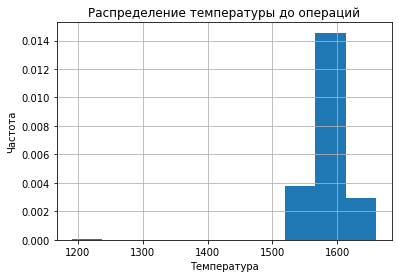

In [82]:
hp(data, 'temp_before', 'Температура', 'Распределение температуры до операций')

Температура плавления стали 1450. Удаляем все, что меньше и строим еще раз.

In [83]:
data = data.drop(index=data[data.temp_before < 1450].index)

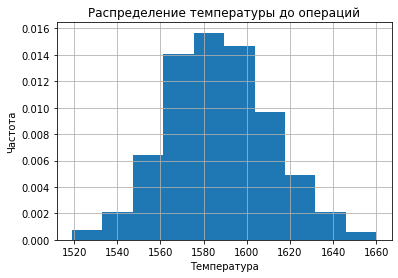

In [84]:
hp(data, 'temp_before', 'Температура', 'Распределение температуры до операций')

Все в порядке. Другая температура.

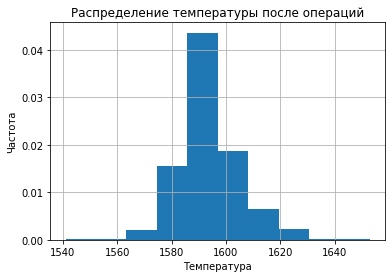

In [85]:
hp(data, 'temp_after', 'Температура', 'Распределение температуры после операций')

Все хорошо. И наконец, газ.

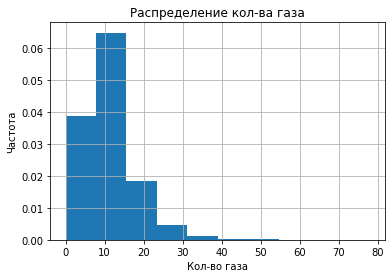

In [86]:
hp(data, 'gas', 'Кол-во газа', 'Распределение кол-ва газа')

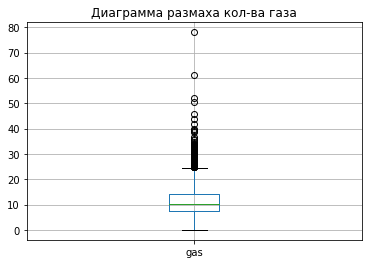

In [87]:
bp(data, 'gas', 'Диаграмма размаха кол-ва газа')

Удалим значения выше 48.

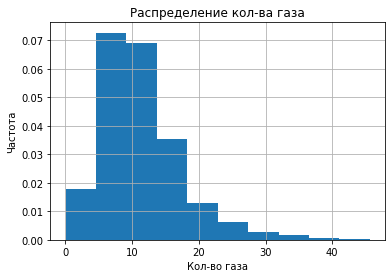

In [88]:
data = data.drop(index=data[data.gas > 48].index)
hp(data, 'gas', 'Кол-во газа', 'Распределение кол-ва газа')

Другое дело.

In [89]:
data = data.dropna()

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 1 to 2499
Data columns (total 19 columns):
temp_before     2320 non-null float64
temp_after      2320 non-null float64
Bulk 1          2320 non-null float64
Bulk 2          2320 non-null float64
Bulk 4          2320 non-null float64
Bulk 6          2320 non-null float64
Bulk 7          2320 non-null float64
Bulk 10         2320 non-null float64
Bulk 11         2320 non-null float64
Bulk 12         2320 non-null float64
Bulk 14         2320 non-null float64
Bulk 15         2320 non-null float64
Wire 1          2320 non-null float64
Wire 2          2320 non-null float64
Wire 4          2320 non-null float64
Wire 6          2320 non-null float64
Wire 7          2320 non-null float64
gas             2320 non-null float64
active_power    2320 non-null float64
dtypes: float64(19)
memory usage: 362.5 KB


**Вывод по Шагу 2**: итак, на данном шаге мы произвели предобработку данных, отобрали признаки, которые будем использовать в модели, собрали все в одну таблицу и удалили аномалии. Получилось 17 признаков, 2320 объектов. До обучения осталась лишь стандартизация данных, которую необходимо будет произвести лишь после деления на выборки.

<h3>Шаг 3: Обучение модели</h3>

Теперь - сама модель. Поделим на выборки. Пропорции: 4:1 (валидационная и обучающая вместе для кросс-валидации).

Отделим перед этим целевой признак.

In [91]:
target = data['temp_after']
features = data.drop(columns=['temp_after'])

In [92]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [93]:
features = features.columns

Стандартизируем данные. 

In [94]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(columns=features, data=scaler.transform(features_train))
features_test = pd.DataFrame(columns=features, data=scaler.transform(features_test))

Из моделей попробуем: гребневую регрессию, случайный лес, градиентный бустинг и метод опорных векторов. Будем также подбирать гиперпараметры.

**Гребневая регрессия**

In [95]:
model1gs = Ridge()
params1 = {'alpha': [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]}
gs1 = GridSearchCV(model1gs, params1, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [96]:
gs1.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

Лучшие гиперпараметры.

In [97]:
gs1.best_params_

{'alpha': 10}

Лучшее МАЕ по результатам кросс валидации у лучшей модели такого вида.

In [98]:
'Лучшее МАЕ: {:.3}'.format(gs1.best_score_ * (-1))

'Лучшее МАЕ: 6.29'

Неплохо, идем дальше.

**Метод опорных векторов**

In [99]:
model2gs = SVR()
params2 = {'C': [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 20], 'kernel' : ['linear', 'poly', 'rbf']}
gs2 = GridSearchCV(model2gs, params2, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [100]:
gs2.fit(features_train, target_train)

C:\Users\Acer\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 20],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

Лучшие параметры.

In [101]:
gs2.best_params_

{'C': 10, 'kernel': 'rbf'}

МАЕ.

In [102]:
'Лучшее МАЕ: {:.3}'.format(gs2.best_score_ * (-1))

'Лучшее МАЕ: 6.12'

Лучше гребневой регрессии, но все еще больше 6.

**Случайный лес**

In [103]:
model3gs = RandomForestRegressor()
params3 = {'max_depth' : [3, 5, 7, 10, 15, 20, 30, 40],
          'n_estimators' : [200, 300],
          'random_state': [12345]}
gs3 = GridSearchCV(model3gs, params3, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [104]:
gs3.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20

Лучшие параметры.

In [105]:
gs3.best_params_

{'max_depth': 10, 'n_estimators': 300, 'random_state': 12345}

МАЕ.

In [106]:
'Лучшее МАЕ: {:.3}'.format(gs3.best_score_ * (-1))

'Лучшее МАЕ: 6.07'

Качество чуть лучше, чем у метода опорных векторов, но все равно - больше 6.

Теперь посмотрим на важность признаков.

In [107]:
fi = pd.DataFrame()
fi['features'] = features
fi['importance'] = gs3.best_estimator_.feature_importances_

Text(0.5, 0, 'Признаки')

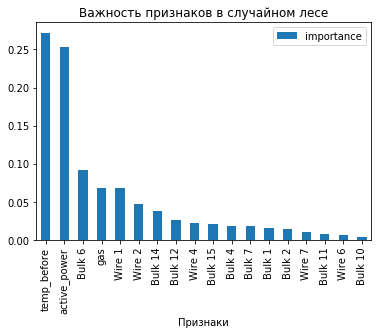

In [108]:
fi.set_index('features').sort_values(by='importance', ascending=False).plot(kind='bar')
plt.title('Важность признаков в случайном лесе')
plt.xlabel('Признаки')

Попробуем убрать признаки с важностью меньше 0.015. Посмотрим на качество такой модели.

In [109]:
gs3.fit(features_train[list(fi[fi['importance'] >= 0.015]['features'].values)], target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20

In [110]:
'Лучшее МАЕ: {:.3}'.format(gs3.best_score_ * (-1))

'Лучшее МАЕ: 6.06'

Хорошо подобрали границу ограничения по важности. Теперь случайный лес будет таким - обученным на признаках с важностью выше 0.15.

**Градиентный бустинг**

In [111]:
model4gs = LGBMRegressor()
params4 = {'max_depth' : [3, 5, 7, 10, 15, 20, 30, 40],
          'n_estimators' : [100, 200, 300]}
gs4 = GridSearchCV(model4gs, params4, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [112]:
gs4.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20, 30, 40],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=

Лучшие параметры.

In [113]:
gs4.best_params_

{'max_depth': 3, 'n_estimators': 100}

МАЕ.

In [114]:
'Лучшее МАЕ: {:.3}'.format(gs4.best_score_ * (-1))

'Лучшее МАЕ: 6.06'

Важность признаков.

Сравним со случайным лесом.

In [115]:
fi['importance2'] = gs4.best_estimator_.feature_importances_
fi['importance2'] = fi['importance2'] / fi['importance2'].sum()

Text(0.5, 0, 'Признаки')

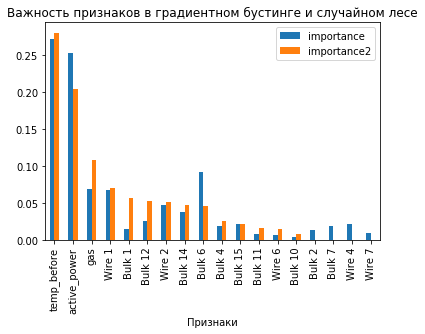

In [116]:
fi.set_index('features').sort_values(by='importance2', ascending=False).plot(kind='bar')
plt.title('Важность признаков в градиентном бустинге и случайном лесе')
plt.xlabel('Признаки')

Два наиболее важных признака также выделены как важные. В остальном - отличия незначительные, но они есть - признаки, которым бустинг присвоил 0, таки больше ценятся в лесу. Также некоторые признаки оценены как важные в бустинге, но имеют не такую важность в лесу.

В любом случае - сильнее всего на температуру после влияют (в порядке убывания важности):

    - температура до,
    - суммарная активная мощность нагрева,
    - количество затраченного газа,
    - примеси: Wire 1, Wire 2, Bulk 12, Bulk 14, Bulk 6.

In [117]:
fi = fi.drop(columns=['importance'])

Теперь график только по бустингу.

Text(0.5, 0, 'Признаки')

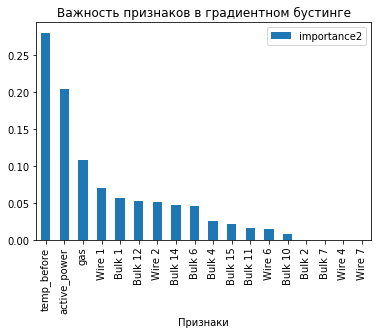

In [118]:
fi.set_index('features').sort_values(by='importance2', ascending=False).plot(kind='bar')
plt.title('Важность признаков в градиентном бустинге')
plt.xlabel('Признаки')

Уберем признаки с важностью 0.

In [119]:
gs4.fit(features_train[list(fi[fi['importance2'] > 0]['features'].values)], target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20, 30, 40],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=

In [120]:
'Лучшее МАЕ: {:.3}'.format(gs4.best_score_ * (-1))

'Лучшее МАЕ: 6.06'

Качество не поменялось, но все равно уберем эти признаки.

**Выводы по Шагу 3**: итак, на данном шаге мы обучили четыре модели, подобрали для них гиперпараметры, а также посмотрели качество их предсказания с помощью кросс-валидации; все четыре модели показали себя хорошо, итоговые МАЕ по моделям:

    - гребневая регрессия: 6.29,
    - SVM: 6.12,
    - случайный лес: 6.06,
    - градиентный бустинг: 6.06.

Лучше всего себя показали градиентный бустинг и случайный лес. Бустинг будет конечной моделью - результатом всей проделанной выше работы.

<h3>Шаг 4: Выводы и финальное тестирование</h3>

Итак - в качестве конечной модели был выбран градиентный бустинг.

In [121]:
final_model = gs4.best_estimator_

Посмотрим качество модели на тестовой выборке.

In [122]:
predictions = final_model.predict(features_test[list(fi[fi['importance2'] > 0]['features'].values)])
mae = mean_absolute_error(predictions, target_test)
'МАЕ лучшей модели на тестовой выборке: {:.3} '.format(mae)

'МАЕ лучшей модели на тестовой выборке: 5.75 '

Получили желаемый показатель - МАЕ меньше 6.

**Вывод по Шагу 4**: на данном шаге была протестирована лучшая модель, получили MAE на тестовой выборке меньше 6 - 5.75.

<h3>ОТЧЕТ</h3>

В плане работы были следующие вещи:

    - предобработка:
           + обработка пропусков,
           + удаление аномалий и пропущенных значений,
    - подготовка данных для обучения:
           + генерация новых признаков,
           + соединение таблиц и группировка, если потребуется,
           + стандартизация, ohe, 
    - выбор различных моделей, обучение, валидация + подбор гиперпараметров, 
    - выводы + отчет.

Было сделано все, кроме One Hot Encoding - это просто не потребовалось. 

Из ключевых шагов работы можно выделить предобработку данных, генерацию новых признаков и обучение моделей (и подбор гиперпараметров).

Из трудностей встретилось: неясная задача, непонимание происходящих физических процессов. Помогли ответы тимлида, консультация и поисковик.

Итоговой моделью выл выбран градиентный бустинг. МАЕ на тестовой выборке: 5.75.